<a href="https://colab.research.google.com/github/kacperkurowski/CE888/blob/master/Assignment/Santander-Customer-Transaction-Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Assignment 2

In [0]:
pip install scikit-plot

In [0]:
import os
import seaborn as sns
from zipfile import ZipFile
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn.model_selection import cross_val_score
import numpy as np

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
os.environ['KAGGLE_USERNAME'] = "kacperkurowski" # username from the json file

os.environ['KAGGLE_KEY'] = "7c927dd985620db03df77b3804e71a95" # key from the json file

#Unzipping Function

In [0]:
def unzip(file):
  with ZipFile(file, 'r') as zip:
    zip.extractall()
    print('extracted: ',file)

##1.Loading Data

In [0]:
!kaggle competitions download -c santander-customer-transaction-prediction # api copied from kaggle

train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
  0% 0.00/462k [00:00<?, ?B/s]
100% 462k/462k [00:00<00:00, 69.9MB/s]


##1.Removing Files that are not used

In [0]:
!rm sample_submission.csv.zip
!ls

sample_data  test.csv.zip  train.csv  train.csv.zip


#1.Unzipping The Files

In [0]:
unzip("/content/train.csv.zip")

extracted:  /content/train.csv.zip


##Loading the files

In [0]:
df_train_Orig = pd.read_csv("train.csv", header = 0, sep = ',', quotechar = '"')

print(df_train_Orig)

             ID_code  target    var_0  ...  var_197  var_198  var_199
0            train_0       0   8.9255  ...   8.5635  12.7803  -1.0914
1            train_1       0  11.5006  ...   8.7889  18.3560   1.9518
2            train_2       0   8.6093  ...   8.2675  14.7222   0.3965
3            train_3       0  11.0604  ...  10.2922  17.9697  -8.9996
4            train_4       0   9.8369  ...   9.5031  17.9974  -8.8104
...              ...     ...      ...  ...      ...      ...      ...
199995  train_199995       0  11.4880  ...   8.5326  16.6660 -17.8661
199996  train_199996       0   4.9149  ...   6.7419  15.9054   0.3388
199997  train_199997       0  11.2232  ...   8.7155  13.8329   4.1995
199998  train_199998       0   9.7148  ...  10.0342  15.5289 -13.9001
199999  train_199999       0  10.8762  ...   8.1857  12.1284   0.1385

[200000 rows x 202 columns]


##Plotting Histogram of Santander-Customer-Transaction-Prediction Train Data

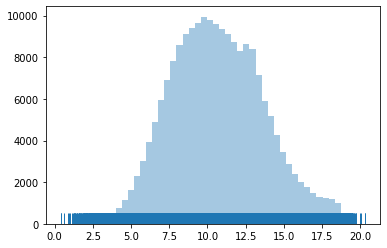

In [0]:
y_df = df_train_Orig["var_0"].copy()
y = y_df.values
sns_plot = sns.distplot(y, kde=False, rug=True)

##Adding Test Columns for testing Covariate Shift

Here i incorporate covariate shift, by placing all the data that is higher than 9.0 into the train column and everything below 9.0 into the test. 
This will cause there to be a covariate shift, as the train and test data use different data.

In [0]:
target_var = "target"
id_var = "ID_code"


df_train = df_train_Orig.where(df_train_Orig["var_0"]>9.0).dropna().drop(columns=[target_var,id_var])
df_test = df_train_Orig.where(df_train_Orig["var_0"]<=9.0).dropna().drop(columns=[target_var,id_var])
df_train['is_test'] = 0
df_test['is_test'] = 1
print(df_train)
print(df_test)

          var_0   var_1    var_2   var_3  ...  var_197  var_198  var_199  is_test
1       11.5006 -4.1473  13.8588  5.3890  ...   8.7889  18.3560   1.9518        0
3       11.0604 -2.1518   8.9522  7.1957  ...  10.2922  17.9697  -8.9996        0
4        9.8369 -1.4834  12.8746  6.6375  ...   9.5031  17.9974  -8.8104        0
5       11.4763 -2.3182  12.6080  8.6264  ...   9.7670  12.5809  -4.7602        0
6       11.8091 -0.0832   9.3494  4.2916  ...   9.1143  10.8869  -3.2097        0
...         ...     ...      ...     ...  ...      ...      ...      ...      ...
199994  12.3925 -5.8821  11.2323  3.9237  ...   9.1164  16.3170  -7.5048        0
199995  11.4880 -0.4956   8.2622  3.5142  ...   8.5326  16.6660 -17.8661        0
199997  11.2232 -5.0518  10.5127  5.6456  ...   8.7155  13.8329   4.1995        0
199998   9.7148 -8.6098  13.6104  5.7930  ...  10.0342  15.5289 -13.9001        0
199999  10.8762 -5.7105  12.1183  8.0328  ...   8.1857  12.1284   0.1385        0

[137385 rows x 

I have implemented covariate shift in the 'var_0' variable by removing it into another array if it is smaller than 9.0. This will allow me to test for the present covariate shift later.

The test and train data is labelled with a 'is_test' variable so that after merging and training on the data is complete, the accuracy can be deduced (AUC score).

#Classifying to Obtain AUC 

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


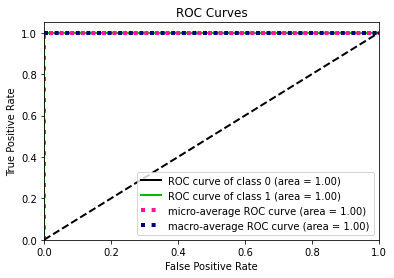

AUC score:  1.0


In [0]:
def classify(MergedData, feature):
  X = MergedData.drop(columns=[feature]) 
  y = MergedData[feature]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
  
  rfc = RandomForestClassifier()
  rfc.fit(X_train, y_train)
  y_test_score = rfc.predict_proba(X_test)
  skplt.metrics.plot_roc_curve(y_test, y_test_score)
  plt.show()
  print('AUC score: ', round(roc_auc_score(y_true=y_test, y_score=y_test_score[:,1]), 4))
  return X,y;

Classified = pd.concat([df_train, df_test], axis = 0)
X,y = classify(Classified, "is_test")

The score is above approximately 0.75, signifying the there is covariate shift present in the data. This is done by testing if the testing data and training data can be differentiated from one another. A result of 1.0 means that the data is very easy to differentiate and therefore signifying a present shift.

#Searching for columns causing Covariate Shift

In [0]:
dropped_columns = []
model = RandomForestClassifier(n_estimators = 25, max_depth = 3,min_samples_leaf = 5)
for n in X.columns:
    score = cross_val_score(model,pd.DataFrame(X[n]),y,cv=2,scoring='roc_auc')
    if (np.mean(score) > 0.8):
        dropped_columns.append(n)
        print(n,np.mean(score))

print(dropped_columns)


var_0 1.0
['var_0']


Variables with covariate shift are detected, as removing them can influence the covariate shift of the data. (this is one method for doing this, however it also usually effect the data depending on how key the removed variables were).

#Removing Features Responsible for Covariate Shift

The var_0 cariable is removed as it has covariate shift present. Removing the variable should reduce the covariate shift of the data, however it may also lose some important information.

(200000, 201)
Histogram of dataset on ' var_0 '


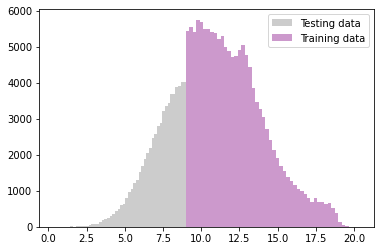

In [0]:
print(Classified.shape)

def histogram(df_test, df_train, data):
  print("Histogram of dataset on '",data,"'")
  histo = sns.distplot(df_test[[data]].values.T[0], color="grey", kde=False, label="Testing data")
  histo = sns.distplot(df_train[[data]].values.T[0], color="purple", kde=False, label="Training data")
  legend = histo.legend()

df_orig = df_train_Orig.drop(columns=[target_var,id_var])
normalized_test=(df_test-df_orig.min())/(df_orig.max()-df_orig.min())
normalized_train=(df_train-df_orig.min())/(df_orig.max()-df_orig.min())

histogram(df_test, df_train,"var_0")

A Histogram of the Training and Testing data can be seen. The testing data is made from the training data as the result column wasnt present in both the training and testing data and it made it difficult to test the accuracy of the classification. The covariate shift can be clearly observed between the grey and purple datasets.

#Classifying after the removal of covariate shift

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


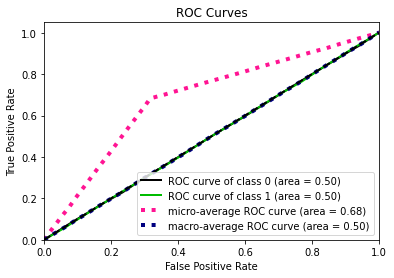

AUC score:  0.4987


In [0]:
unused,unused2 = classify(Classified.drop(columns=['var_0']),"is_test")

After the covariate shift was completely removed from the data it can be seen that the result of the classifier is approximately 0.5. This signifiies that the classifier couldnt differentiate between testing and training data, meaning that covariate shift was succesfully removed.

In [0]:
def classify_multiple(train_df, test_df, feature):

  X_train = train_df.drop(columns=[feature])
  y_train = train_df[feature]

  X_test = test_df.drop(columns=[feature])
  y_test = test_df[feature]
  
  mixed = RandomForestClassifier()
  mixed.fit(X_train, y_train)
  y_test_score = mixed.predict_proba(X_test)
  skplt.metrics.plot_roc(y_test, y_test_score)
  plt.show()
  print('AUC score: ', round(roc_auc_score(y_true=y_test, y_score=y_test_score[:,1]), 4))


This function was made because the data used already has a premade covariate shift, and it allows for this data to be taken and not be randomised any more. It still uses the RandomForestClassifier.

#Checking performance with covariate shift present

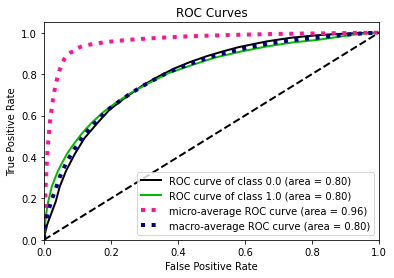

AUC score:  0.7985


In [0]:
df_train = df_train_Orig.where(df_train_Orig["var_0"]>9.0).dropna().drop(columns=[id_var])
df_test = df_train_Orig.where(df_train_Orig["var_0"]<=9.0).dropna().drop(columns=[id_var])
classify_multiple(df_train, df_test, "target")

As covariate shift has been implemented into the data, this comes out as a 0.8 AUC value, signifying that the covariate shift is present. (above approximately 0.8 signified covariate shift)
The removal of covariate shift should increase the AUC as it classifies the data set more accurately.

#Checking performance after the removal of covariate shift

The covariate shift column is dropped and the classifier analysed to check for an improvement.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


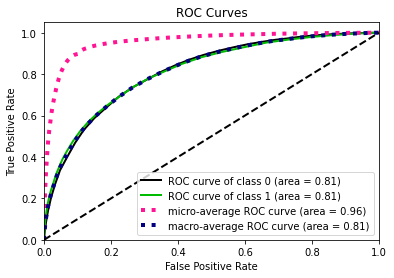

AUC score:  0.8147


(         var_1    var_2   var_3    var_4  ...  var_196  var_197  var_198  var_199
 0      -6.7863  11.9081  5.0930  11.4607  ...   7.8784   8.5635  12.7803  -1.0914
 1      -4.1473  13.8588  5.3890  12.3622  ...   8.1267   8.7889  18.3560   1.9518
 2      -2.7457  12.0805  7.8928  10.5825  ...  -6.5213   8.2675  14.7222   0.3965
 3      -2.1518   8.9522  7.1957  12.5846  ...  -2.9275  10.2922  17.9697  -8.9996
 4      -1.4834  12.8746  6.6375  12.2772  ...   3.9267   9.5031  17.9974  -8.8104
 ...        ...      ...     ...      ...  ...      ...      ...      ...      ...
 199995 -0.4956   8.2622  3.5142  10.3404  ...   2.1661   8.5326  16.6660 -17.8661
 199996 -2.4484  16.7052  6.6345   8.3096  ...  -2.1651   6.7419  15.9054   0.3388
 199997 -5.0518  10.5127  5.6456   9.3410  ...   1.2832   8.7155  13.8329   4.1995
 199998 -8.6098  13.6104  5.7930  12.5173  ...   6.7980  10.0342  15.5289 -13.9001
 199999 -5.7105  12.1183  8.0328  11.5577  ...  -2.2342   8.1857  12.1284   0.1385
 
 [

In [0]:
df_no_covariate = df_train_Orig.drop(columns=[id_var,"var_0"])
classify(df_no_covariate,"target")

The performance is consistantly (code was re-ran multiple times) higher from the classifier after the removal of co-variate shift. This is result is slightly better than that before the co-variate shift was removed, however the difference in performance is very small as the variable 'var_0' may not have had a big impact towards the shift. On top of this, as there are 200 variables in the data-set, a change to a single one would only have a small impact on the overall performance. 